#### Feature Selection with Hypothesis Testing and Feature Ranking

Some section in this notebook were taken feom Kaggle. We put them in the references.

After exploration statistical test we decide to use the Hypothesis testing (significance (Statsmodels)) and Machine learning method (Feature ranking) to compare with the article 'comprehensive-data-exploration-with-python' from kaggle.
In case of Top-5 accuracy, the result of (correlation + Hypothesis testing + Feature ranking) show that 4/4 are correctly rank.

Using TensorFlow backend.


In [1]:
'''
ref
https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models
https://en.wikipedia.org/wiki/Feature_selection
https://chrisalbon.com/machine_learning/linear_regression/effect_of_alpha_on_lasso_regression/

# dataset explantion
------------------------------------------------------------

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
https://stats.stackexchange.com/questions/346720/can-log-likelihood-function-be-negative

ignificance p-value
Multicolinearlity
backward, forward, stepwise

https://www.kaggle.com/codename007/home-credit-complete-eda-feature-importance
'''

'\nref\nhttps://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models\nhttps://en.wikipedia.org/wiki/Feature_selection\nhttps://chrisalbon.com/machine_learning/linear_regression/effect_of_alpha_on_lasso_regression/\n\n# dataset explantion\n------------------------------------------------------------\n\nhttps://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python\nhttps://stats.stackexchange.com/questions/346720/can-log-likelihood-function-be-negative\n\nignificance p-value\nMulticolinearlity\nbackward, forward, stepwise\n\nhttps://www.kaggle.com/codename007/home-credit-complete-eda-feature-importance\n'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import (RidgeCV, LassoCV)
import warnings
warnings.filterwarnings('ignore')

In [4]:
df_train = pd.read_csv('Dataset/House-Prices-Advanced-Regression-Techniques-master/train.csv')
'''
The important features would be
- OverallQual
- YearBuilt.
- TotalBsmtSF.
- GrLivArea.
'''

'\nThe important features would be\n- OverallQual\n- YearBuilt.\n- TotalBsmtSF.\n- GrLivArea.\n'

#### <font color = lightblue>Define Functions

In [5]:
def getting_mean_from_table(size_row, list_start):
    for i in range(size_row):
        mean = round(feature_matrix_du.iloc[i,:].mean(), 2)
        list_start.append(mean)
    return list_start


def distribution_and_QQ5(df,A,B,C,D,E):
    l = [A,B,C,D,E]
    x = 1; y = len(l)+1
    plt.figure(figsize=(18, 4))
    for i in l:
        plt.subplot(2,5,x)
        sns.distplot(df[i], fit=norm, fit_kws={"color":"c"}, color = 'y')
        plt.tight_layout()

        plt.subplot(2,5,y)
        stats.probplot(df[i], plot=plt)
        plt.tight_layout()
        
        x += 1
        y += 1

        
def distribution_and_QQ4(df,A,B,C,D):
    l = [A,B,C,D]
    x = 1; y = len(l)+1
    plt.figure(figsize=(18, 4))
    for i in l:
        plt.subplot(2,5,x)
        sns.distplot(df[i], fit=norm, fit_kws={"color":"c"}, color = 'y')
        plt.tight_layout()

        plt.subplot(2,5,y)
        stats.probplot(df[i], plot=plt)
        plt.tight_layout()
        
        x += 1
        y += 1        

### Data preparation

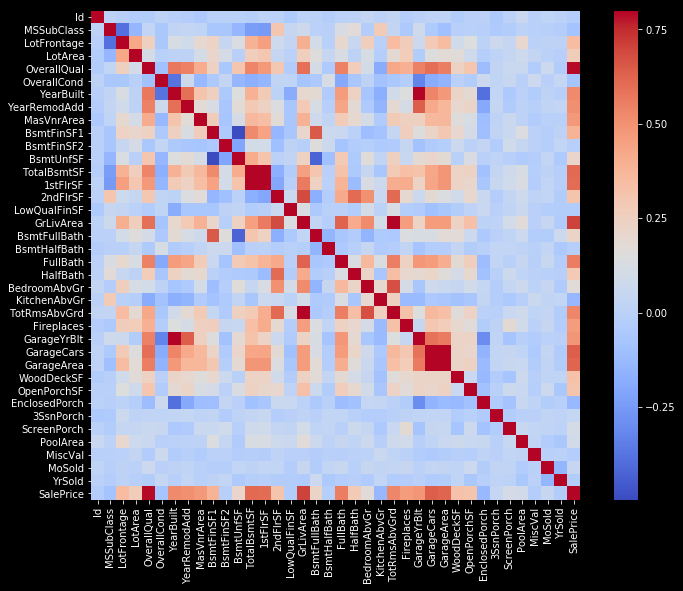

In [6]:
plt.style.use(['dark_background'])
corrmat = df_train.corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, cmap="coolwarm");
# see https://docs.google.com/presentation/d/1t_2EtHOTa4YX9dKgse4wCJW7Y_kraryjsurGyPlHoug/edit?usp=sharing

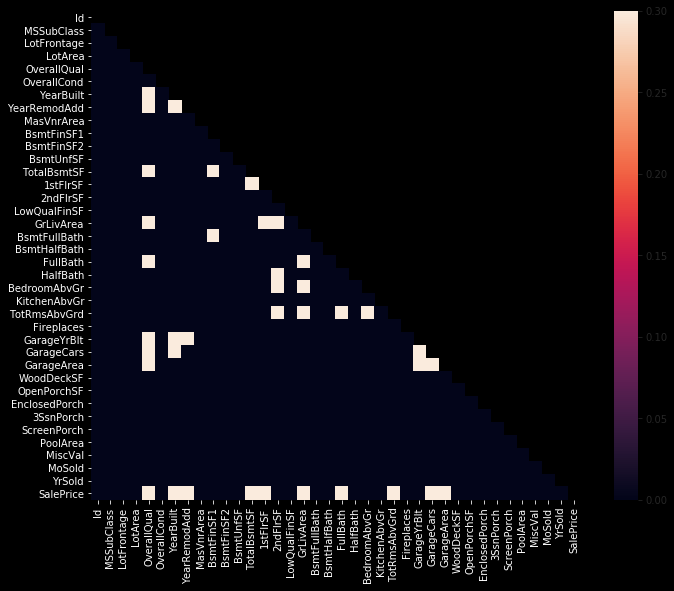

In [7]:
plt.style.use(['dark_background'])
corrmat_05 = corrmat > 0.5
plt.subplots(figsize=(12, 9))
mask = np.zeros_like(corrmat_05)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"): ax = sns.heatmap(corrmat_05, mask=mask, vmax=.3, square=True)
# As we can see, there are 11 the coorelation coefficient which high related to 'SalePrice' 

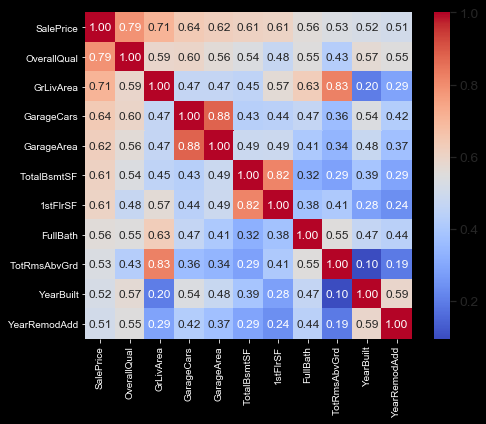

In [8]:
#saleprice correlation matrix
plt.subplots(figsize=(8, 6))
k = 11 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values, cmap='coolwarm')
plt.show()

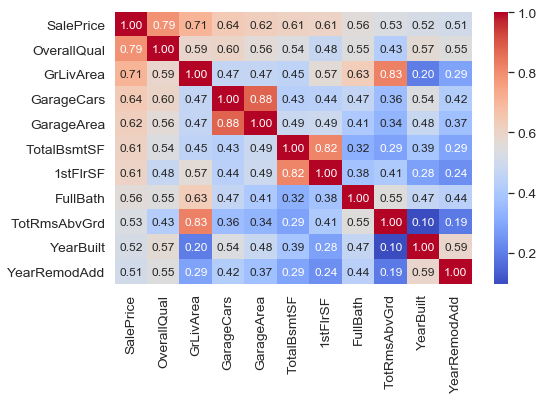

In [9]:
# Pearson correlation: 
# Since Pearson corr does not assume normal distribution in data, we will compare the result to normal corr when 0 implying no correlation
# https://stats.stackexchange.com/questions/3730/pearsons-or-spearmans-correlation-with-non-normal-data

plt.subplots(figsize=(8, 5))
sns.heatmap(df_train.loc[:,cols].corr(method='pearson'), annot=True, fmt='.2f',annot_kws={'size': 12}, cmap='coolwarm')

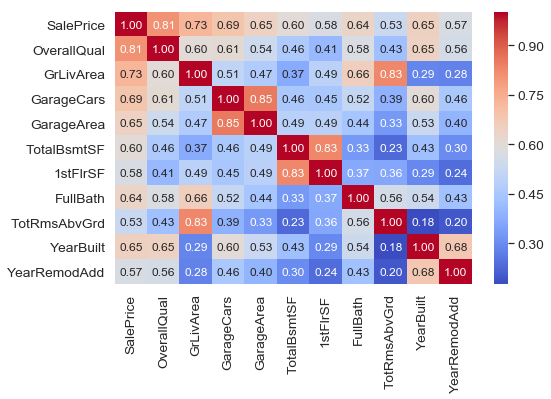

In [10]:
# Spearman; ranking
plt.subplots(figsize=(8, 5))
sns.heatmap(df_train.loc[:,cols].corr(method='spearman'), annot=True, fmt='.2f',annot_kws={'size': 12}, cmap='coolwarm')
# https://stackoverflow.com/questions/45843761/spearman-correlation-with-corrwith-python

In [11]:
df_train.isnull().any()

Id               False
MSSubClass       False
MSZoning         False
LotFrontage       True
LotArea          False
Street           False
Alley             True
LotShape         False
LandContour      False
Utilities        False
LotConfig        False
LandSlope        False
Neighborhood     False
Condition1       False
Condition2       False
BldgType         False
HouseStyle       False
OverallQual      False
OverallCond      False
YearBuilt        False
YearRemodAdd     False
RoofStyle        False
RoofMatl         False
Exterior1st      False
Exterior2nd      False
MasVnrType        True
MasVnrArea        True
ExterQual        False
ExterCond        False
Foundation       False
                 ...  
BedroomAbvGr     False
KitchenAbvGr     False
KitchenQual      False
TotRmsAbvGrd     False
Functional       False
Fireplaces       False
FireplaceQu       True
GarageType        True
GarageYrBlt       True
GarageFinish      True
GarageCars       False
GarageArea       False
GarageQual 

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [13]:
# To simplify problem, we will delete all of missing value and corresponding value in each feature

#dealing with missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #checking that there's no missing data missing...

0

In [14]:
df_train_numeric = df_train.select_dtypes(include=['int64', 'float64'])
df_train_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 35 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
LotArea          1459 non-null int64
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
BsmtFinSF1       1459 non-null int64
BsmtFinSF2       1459 non-null int64
BsmtUnfSF        1459 non-null int64
TotalBsmtSF      1459 non-null int64
1stFlrSF         1459 non-null int64
2ndFlrSF         1459 non-null int64
LowQualFinSF     1459 non-null int64
GrLivArea        1459 non-null int64
BsmtFullBath     1459 non-null int64
BsmtHalfBath     1459 non-null int64
FullBath         1459 non-null int64
HalfBath         1459 non-null int64
BedroomAbvGr     1459 non-null int64
KitchenAbvGr     1459 non-null int64
TotRmsAbvGrd     1459 non-null int64
Fireplaces       1459 non-null int64
GarageCars       1459 non-null int64
Garag

### Outlier detection with IsolationForest

In [15]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(n_estimators=100, max_samples='auto', verbose=2, bootstrap = False, n_jobs=-1, random_state=42)
iso_forest.fit(df_train_numeric)
predict = iso_forest.predict(df_train_numeric)

Building estimator 1 of 9 for this parallel run (total 100)...
Building estimator 1 of 9 for this parallel run (total 100)...
Building estimator 1 of 9 for this parallel run (total 100)...
Building estimator 1 of 9 for this parallel run (total 100)...
Building estimator 1 of 8 for this parallel run (total 100)...
Building estimator 1 of 8 for this parallel run (total 100)...
Building estimator 1 of 8 for this parallel run (total 100)...
Building estimator 1 of 8 for this parallel run (total 100)...
Building estimator 1 of 8 for this parallel run (total 100)...
Building estimator 1 of 8 for this parallel run (total 100)...
Building estimator 1 of 8 for this parallel run (total 100)...
Building estimator 1 of 8 for this parallel run (total 100)...
Building estimator 2 of 9 for this parallel run (total 100)...Building estimator 2 of 8 for this parallel run (total 100)...

Building estimator 2 of 8 for this parallel run (total 100)...
Building estimator 2 of 8 for this parallel run (total 

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:    0.0s remaining:    0.2s
[Parallel(n_jobs=12)]: Done  10 out of  12 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:    0.0s finished


In [16]:
df_train['anomaly'] = predict
df_train_numeric['anomaly'] = predict

In [17]:
df_train.head(5)

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,anomaly
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,2008,WD,Normal,208500,1
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,5,2007,WD,Normal,181500,1
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,9,2008,WD,Normal,223500,1
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,2,2006,WD,Abnorml,140000,1
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,12,2008,WD,Normal,250000,1


In [18]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer

In [19]:
# https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class
# Multicolinearity detector

from statsmodels.stats.outliers_influence import variance_inflation_factor

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0, impute=True, impute_strategy='median'):
        # From looking at documentation, values between 5 and 10 are "okay".
        # Above 10 is too high and so should be removed.
        self.thresh = thresh
        
        # The statsmodel function will fail with NaN values, as such we have to impute them.
        # By default we impute using the median value.
        # This imputation could be taken out and added as part of an sklearn Pipeline.
        if impute:
            self.imputer = Imputer(strategy=impute_strategy)

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [20]:
df_without_outlier = df_train[df_train['anomaly'] == 1]
df_numeric_without_outlier = df_train_numeric[df_train_numeric['anomaly'] == 1]

df_numeric_without_outlier = df_numeric_without_outlier.drop(['anomaly', 'Id'], axis =1)
indepen_va = df_numeric_without_outlier.drop(['SalePrice'], axis =1)
tar_va = df_numeric_without_outlier.SalePrice

## Hypothesis testing + MinMaxScaler

In [21]:
import statsmodels.api as sm
'''
endog => y (target)
exog => x (independent variable)

AIC = 2k + 2log(L)
    = 2(num of parameters) + 2(log-likelihood) 
    = complexity + how well model get explain the data

Dubin-Watson:
    A value of 2.0 means there is no autocorrelation detected in the sample. 
Values from zero to 2.0 indicate positive autocorrelation and values 
from 2.0 to 4.0 indicate negative autocorrelation.
'''

'\nendog => y (target)\nexog => x (independent variable)\n\nAIC = 2k + 2log(L)\n    = 2(num of parameters) + 2(log-likelihood) \n    = complexity + how well model get explain the data\n\nDubin-Watson:\n    A value of 2.0 means there is no autocorrelation detected in the sample. \nValues from zero to 2.0 indicate positive autocorrelation and values \nfrom 2.0 to 4.0 indicate negative autocorrelation.\n'

In [22]:
multi_regressor = sm.OLS(tar_va, indepen_va).fit()
print(multi_regressor.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     2793.
Date:                Tue, 28 May 2019   Prob (F-statistic):               0.00
Time:                        09:30:23   Log-Likelihood:                -15013.
No. Observations:                1313   AIC:                         3.009e+04
Df Residuals:                    1282   BIC:                         3.025e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
MSSubClass     -122.1588     19.605     -6.231

In [23]:
mm = MinMaxScaler()
mm_indepen_va = mm.fit(indepen_va).transform(indepen_va)
mm_indepen_va = pd.DataFrame(mm_indepen_va, columns = indepen_va.columns)
# transform to list since indice is not same because we create another data frame in mm_indepen_va
mm_multi_regressor = sm.OLS(list(tar_va), 
                            mm_indepen_va[['OverallQual', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 
                                           'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'GarageArea', 'GarageCars']]).fit()
print(mm_multi_regressor.summary())
'''R-squr more thatn 1 due to we did not Minmaxscale the target'''
# https://stackoverflow.com/questions/37144913/getting-valueerror-the-indices-for-endog-and-exog-are-not-aligned

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                     907.996
Model:                            OLS   Adj. R-squared:                914.256
Method:                 Least Squares   F-statistic:                    -145.0
Date:                Tue, 28 May 2019   Prob (F-statistic):               1.00
Time:                        09:30:23   Log-Likelihood:                -15305.
No. Observations:                1313   AIC:                         3.063e+04
Df Residuals:                    1304   BIC:                         3.067e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
OverallQual   9.516e+04   8003.940     11.889   

'R-squr more thatn 1 due to we did not Minmaxscale the target'

In [24]:
def sig_pVal(tar_va, indepen_va, sig_lv):
    regressor = sm.OLS(list(tar_va), indepen_va).fit()
    pvals = pd.DataFrame(regressor.pvalues, columns = ['p-value'])
    sig_p = pvals[pvals.loc[:,'p-value'].values < sig_lv]
    
    return sig_p


# def regressor_with_sig_pVal(tar_va, indepen_va, sig_lv):
#     regressor = sm.OLS(list(tar_va), indepen_va).fit()
#     pvals = pd.DataFrame(regressor.pvalues, columns = ['p-value'])
    
#     sig_p = pvals[pvals.loc[:,'p-value'].values < sig_lv]
#     sig_indepen_va = indepen_va[sig_p.T.columns]
#     sig_regressor = sm.OLS(list(tar_va), sig_indepen_va).fit()
    
#     return sig_regressor.summary()

In [25]:
sig_lv = 0.05
pvals = pd.DataFrame(mm_multi_regressor.pvalues, columns = ['p-value'])
sig_p = pvals[pvals.loc[:,'p-value'].values < sig_lv]
sig_indepen_va = mm_indepen_va[sig_p.T.columns]
sig_regressor = sm.OLS(list(tar_va), sig_indepen_va).fit()
sig_regressor.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                     907.996
Model:                            OLS   Adj. R-squared:                914.256
Method:                 Least Squares   F-statistic:                    -145.0
Date:                Tue, 28 May 2019   Prob (F-statistic):               1.00
Time:                        09:30:23   Log-Likelihood:                -15305.
No. Observations:                1313   AIC:                         3.063e+04
Df Residuals:                    1304   BIC:                         3.067e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
OverallQual   9.516e+04   8003.940     11.889      0.000    7.95e+04    1.11e+05
GrLivArea      1.69e+05   9316.302     18.141      0.000    1.51e+05    1.87e+05
TotalBsmtSF   7.208e+04   1.15e+04      6.270      0.000    4.95e+04    9.46e+04
1stFlrSF       1.93e+04   7143.751      2.701      0.007    5281.536    3.33e+04
FullBath     -2.843e+04   6739.087     -4.219      0.000   -4.17e+04   -1.52e+04
TotRmsAbvGrd -2.883e+04   7439.253     -3.876      0.000   -4.34e+04   -1.42e+04
YearBuilt     3.797e+04   5118.949      7.417      0.000    2.79e+04     4.8e+04
GarageArea    4.635e+04   1.16e+04      4.003      0.000    2.36e+04    6.91e+04
GarageCars    1.991e+04   9908.579      2.009      0.045     466.897    3.93e+04
==============================================================================
Omnibus:                      249.143   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1172.313
Skew:                           0.811   Prob(JB):                    2.73e-255
Kurtosis:                       7.336   Cond. No.                         27.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
mm_indepen_va = mm.fit(indepen_va).transform(indepen_va)
mm_indepen_va = pd.DataFrame(mm_indepen_va, columns = indepen_va.columns)

mm_multi_regressor = sm.OLS(list(tar_va), mm_indepen_va[sig_p.T.columns]).fit()
print(mm_multi_regressor.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                     907.996
Model:                            OLS   Adj. R-squared:                914.256
Method:                 Least Squares   F-statistic:                    -145.0
Date:                Tue, 28 May 2019   Prob (F-statistic):               1.00
Time:                        09:30:24   Log-Likelihood:                -15305.
No. Observations:                1313   AIC:                         3.063e+04
Df Residuals:                    1304   BIC:                         3.067e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
OverallQual   9.516e+04   8003.940     11.889   

### Feature ranking
(aka, feature selection, variable selection, attribute selection or variable subset selection) is the process of selecting a subset of relevant features (variables, predictors) for use in model construction. Feature selection techniques are used for four reasons:

* simplification of models to make them easier to interpret by researchers/users, shorter training times,
* to avoid the curse of dimensionality,
* enhanced generalization by reducing overfitting (formally, reduction of variance))

This sort of feature ranking can be really useful, especially if one has many many features in the dataset and would like to trim or cut off features that contribute negligibly.


Manually seletion Result from: https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
- OverallQual
- YearBuilt.
- TotalBsmtSF.
- GrLivArea.

In [27]:
Y = tar_va.values
X = sig_indepen_va.as_matrix()
colnames = sig_indepen_va.columns

ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

lr = LinearRegression(normalize=True)
lr.fit(X,Y)
rfe = RFE(lr, n_features_to_select=1, verbose =3 ) # n_features_to_select: The number of features to select. If None, half of the features are selected.
rfe.fit(X,Y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

lr = LinearRegression(normalize=True)
lr.fit(X,Y)
ranks["LinReg"] = ranking(np.abs(lr.coef_), colnames)

ridge = Ridge(alpha = 7)
ridge.fit(X,Y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

lasso = Lasso(alpha=.05)
lasso.fit(X, Y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

feature_matrix_du = pd.DataFrame(ranks)
feature_matrix = pd.DataFrame(ranks)
feature_matrix["Mean"] = 0
feature_matrix['Mean'] = getting_mean_from_table(feature_matrix.shape[0], []);

Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


In [28]:
# Hypothesis tesing + Feature Ranking
'''
Important features
- OverallQual
- YearBuilt.
- TotalBsmtSF.
- GrLivArea. '''
feature_matrix.sort_values(by=['Mean'], ascending=False)

,RFE,LinReg,Ridge,Lasso,Mean
OverallQual,1.00,0.98,1.00,0.98,0.99
GrLivArea,0.75,1.00,0.90,1.00,0.91
TotalBsmtSF,0.88,0.69,0.57,0.69,0.71
GarageArea,0.62,0.37,0.36,0.37,0.43
YearBuilt,0.50,0.34,0.44,0.34,0.40
1stFlrSF,0.25,0.10,0.31,0.10,0.19
FullBath,0.38,0.12,0.00,0.12,0.16
GarageCars,0.12,0.08,0.24,0.08,0.13
TotRmsAbvGrd,0.00,0.00,0.20,0.00,0.05
